<a href="https://colab.research.google.com/github/dragoa/MachineLearning/blob/TAI/TAI/03_Adversarial_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Improving robustness through Adversarial Training

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/zangobot/teaching_material/blob/HEAD/03-AdversarialTraining.ipynb)

One possible way to counter the presence of adversarial examples is through **Adversarial Training**, that formalizes the training of a classifier as the following optimization problem:

$$
    \min_\boldsymbol{\theta} \max_{\boldsymbol{\delta}} \mathbb{E}_{(x, y)\sim D} [ L(\boldsymbol{x} + \boldsymbol{\delta}, y_i; \boldsymbol{\theta}) ]
  \\
  s.t.\quad ||\delta||_p \le \epsilon
  \\
  \text{subject to} \quad \boldsymbol{l}_b \preccurlyeq \boldsymbol{x} + \boldsymbol{\delta} \preccurlyeq \boldsymbol{l}_u
$$

In words, the goal of adversarial training is finding a model that fits input data (the outer minimization), by taking into account the *worst* manipulation that can be applied to them (the inner maximisation) [1].
In practice, finding a solution to this problem is very hard, as the terms that are optimized have a direct impact on both the inner and the outer problem (and they can not be separated).

Hence, we can provide an *approximation* of this objective, that alternatively compute both optimization problems:
* fits a model on clean data;
* compute adversarial examples with a specific attack;
* combine clean and adversarial data (with correct label) and fit the classifier again;
* repeat the process.

We will start by looking at a simple 2D case first, and we will scale up to more difficult problems at the end of the notebook.

[1] Madry et al. "Towards deep learning models resistant to adversarial attacks", ICLR 2018, https://arxiv.org/pdf/1706.06083.pdf

In [1]:
try:
    import secml
    import torch
except ImportError:
    %pip install git+https://github.com/pralab/secml
    %pip install torch
    %pip install foolbox

  Cloning https://github.com/pralab/secml to /tmp/pip-req-build-x4jmxdr5
  Running command git clone --filter=blob:none --quiet https://github.com/pralab/secml /tmp/pip-req-build-x4jmxdr5
  Resolved https://github.com/pralab/secml to commit e7463f2114ddf507a32a74c80e401574d7d9e086
  Preparing metadata (setup.py) ... done
  Created wheel for secml: filename=secml-0.15.6-py3-none-any.whl size=463965 sha256=7864a3edcde41ae9694b8a33b9923c7c574238a631cb55ef940977d6cbb89dcd
  Stored in directory: /tmp/pip-ephem-wheel-cache-b889j4s5/wheels/22/d7/97/6c54183f8e63358a946e938cc5ca912832afe4a0b9d9b3d736
Successfully built secml
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.3 MB/s eta 0:00:00


In [2]:
random_state = 999

n_features = 2  # number of features
n_samples = 1250  # number of samples
centers = [[-2, -2], [2, -2], [2, 2], [-2, 2]]  # centers of the clusters
cluster_std = 0.5  # standard deviation of the clusters
n_classes = len(centers)  # number of classes

from secml.data.loader import CDLRandomBlobs

dataset = CDLRandomBlobs(n_features=n_features,
                         centers=centers,
                         cluster_std=cluster_std,
                         n_samples=n_samples,
                         random_state=random_state).load()

n_tr = 1000  # number of training set samples
n_ts = 250  # number of test set samples

# split in training and test
from secml.data.splitter import CTrainTestSplit

splitter = CTrainTestSplit(
    train_size=n_tr, test_size=n_ts, random_state=random_state)
tr, ts = splitter.split(dataset)

# normalize the data
from secml.ml.features import CNormalizerMinMax

nmz = CNormalizerMinMax()
tr.X = nmz.fit_transform(tr.X)
ts.X = nmz.transform(ts.X)

2023-12-17 16:57:59,903 - secml.settings - INFO - New `SECML_HOME_DIR` created: /root/secml-data
2023-12-17 16:57:59,903 - secml.settings - INFO - New `SECML_HOME_DIR` created: /root/secml-data


INFO:secml.settings:New `SECML_HOME_DIR` created: /root/secml-data


2023-12-17 16:57:59,912 - secml.settings - INFO - Default configuration file copied to: /root/secml-data/secml.conf
2023-12-17 16:57:59,912 - secml.settings - INFO - Default configuration file copied to: /root/secml-data/secml.conf


INFO:secml.settings:Default configuration file copied to: /root/secml-data/secml.conf


2023-12-17 16:57:59,919 - secml.settings - INFO - New `SECML_DS_DIR` created: /root/secml-data/datasets
2023-12-17 16:57:59,919 - secml.settings - INFO - New `SECML_DS_DIR` created: /root/secml-data/datasets


INFO:secml.settings:New `SECML_DS_DIR` created: /root/secml-data/datasets


2023-12-17 16:57:59,924 - secml.settings - INFO - New `SECML_MODELS_DIR` created: /root/secml-data/models
2023-12-17 16:57:59,924 - secml.settings - INFO - New `SECML_MODELS_DIR` created: /root/secml-data/models


INFO:secml.settings:New `SECML_MODELS_DIR` created: /root/secml-data/models


2023-12-17 16:57:59,930 - secml.settings - INFO - New `SECML_EXP_DIR` created: /root/secml-data/experiments
2023-12-17 16:57:59,930 - secml.settings - INFO - New `SECML_EXP_DIR` created: /root/secml-data/experiments


INFO:secml.settings:New `SECML_EXP_DIR` created: /root/secml-data/experiments


2023-12-17 16:57:59,936 - secml.settings - INFO - New `SECML_LOGS_DIR` created: /root/secml-data/logs
2023-12-17 16:57:59,936 - secml.settings - INFO - New `SECML_LOGS_DIR` created: /root/secml-data/logs


INFO:secml.settings:New `SECML_LOGS_DIR` created: /root/secml-data/logs


2023-12-17 16:57:59,943 - secml.settings - INFO - New `SECML_PYTORCH_DIR` created: /root/secml-data/pytorch-data
2023-12-17 16:57:59,943 - secml.settings - INFO - New `SECML_PYTORCH_DIR` created: /root/secml-data/pytorch-data


INFO:secml.settings:New `SECML_PYTORCH_DIR` created: /root/secml-data/pytorch-data


In [3]:
import torch
from torch import nn
from torch import optim
from secml.ml.classifiers import CClassifierPyTorch
from secml.ml.peval.metrics import CMetricAccuracy


# creation of the multiclass classifier
class Net(nn.Module):
    def __init__(self, n_features, n_hidden, n_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_features, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.fc3 = nn.Linear(n_hidden, n_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# torch model creation
net = Net(n_features=n_features, n_classes=n_classes, n_hidden=100)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),
                      lr=0.001, momentum=0.9)

# wrap torch model in CClassifierPyTorch class (classifier not adversarialy trained)
clean_clf = CClassifierPyTorch(model=net,
                         loss=criterion,
                         optimizer=optimizer,
                         input_shape=(n_features,),
                         random_state=random_state)

# fit the classifier with training data
clean_clf.fit(tr.X, tr.Y)

# compute predictions on a test set
y_pred = clean_clf.predict(ts.X)

# Evaluate the accuracy of the classifier
metric = CMetricAccuracy()
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)

print("Accuracy on test set: {:.2%}".format(acc))

Accuracy on test set: 100.00%


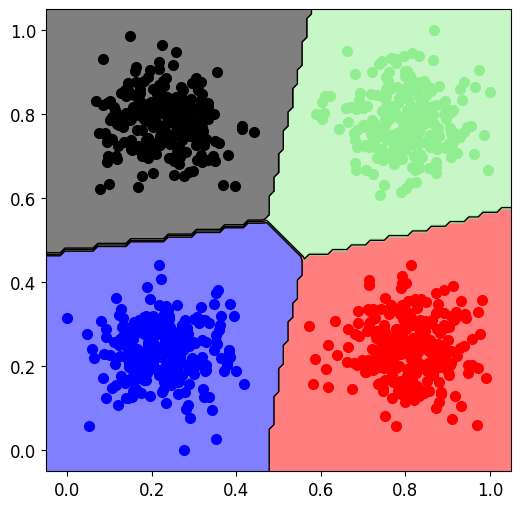

In [19]:
%matplotlib inline

# plot the samples and the decision function of the classifier
from secml.figure import CFigure

fig = CFigure()
fig.sp.plot_ds(tr)
fig.sp.plot_decision_regions(clean_clf, plot_background=True,
                             n_grid_points=100)
fig.show()

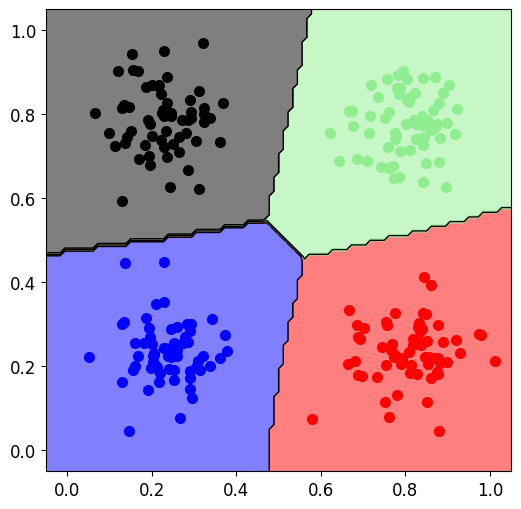

In [20]:
fig = CFigure()
fig.sp.plot_ds(ts)
fig.sp.plot_decision_regions(clean_clf, plot_background=True,
                             n_grid_points=100)
fig.show()

# Implementing a naive version of Adversarial Training

As said before, we need to create a loop that iteratively compute adversarial attacks against the classifier, and use them inside the next training of the classifier itself.

As we can see this attack is very slow. Everytime I need to retrain the net!

Adversarial training: iteration 0


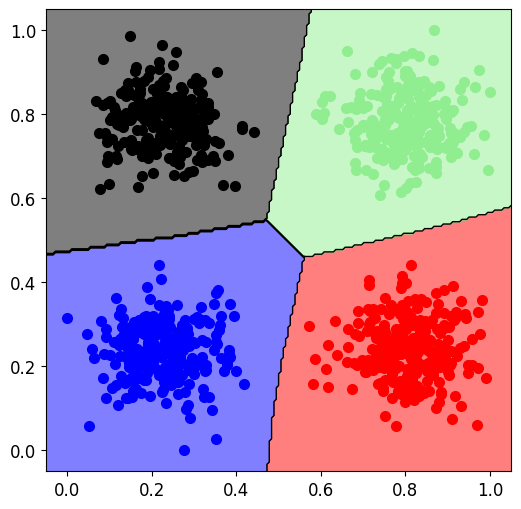

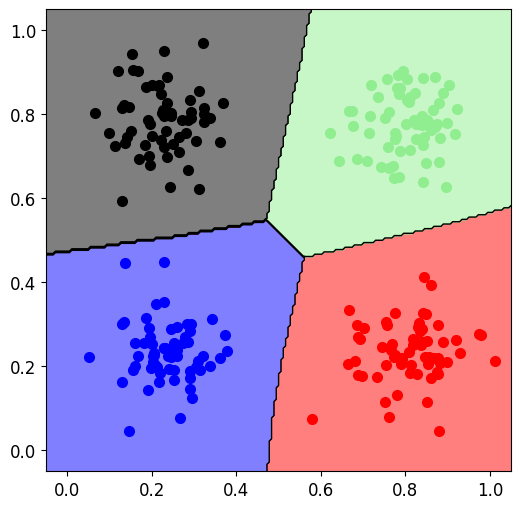

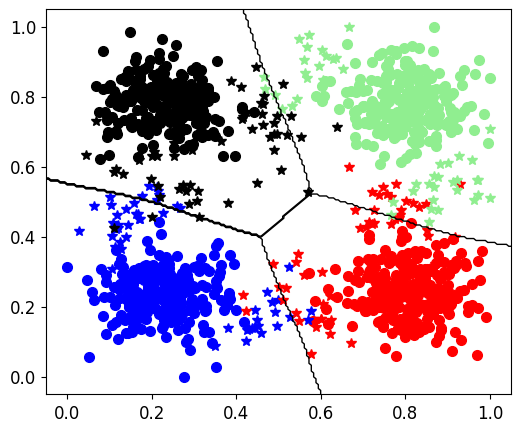

Adversarial training: iteration 1


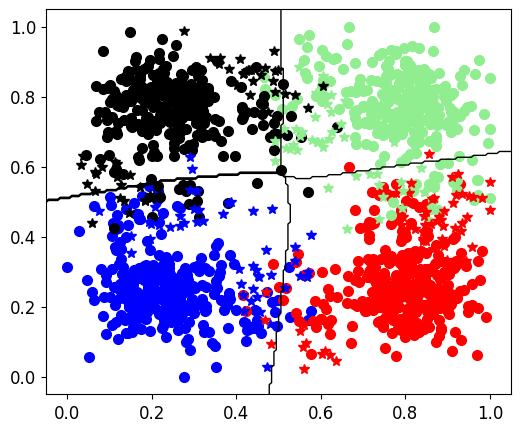

Adversarial training: iteration 2


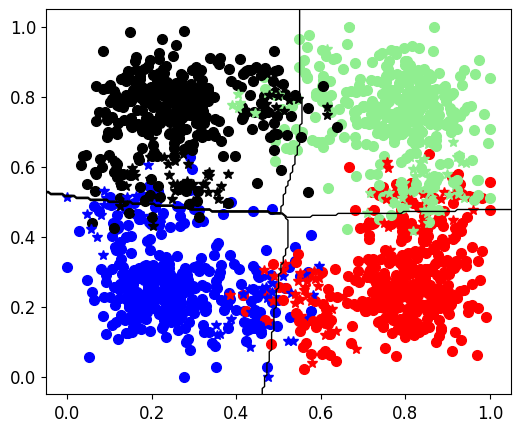

Adversarial training: iteration 3


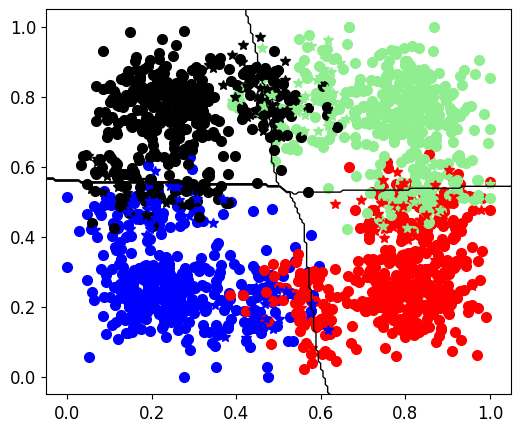

Adversarial training: iteration 4


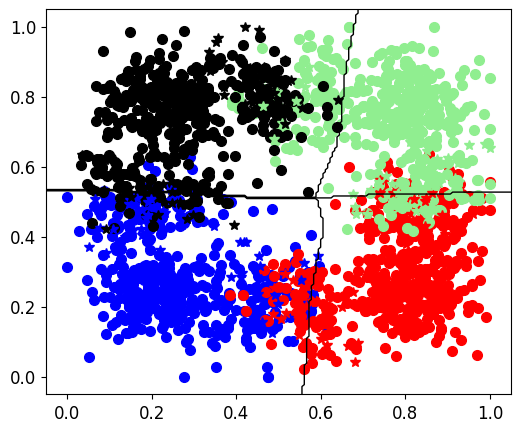

Adversarial training: iteration 5


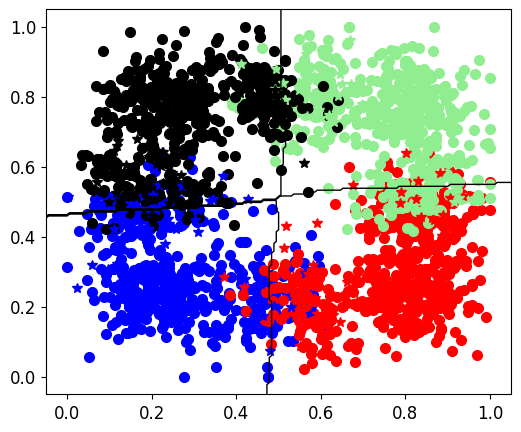

Adversarial training: iteration 6


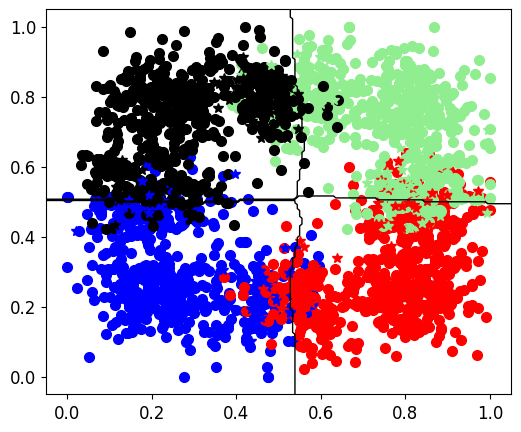

Adversarial training: iteration 7


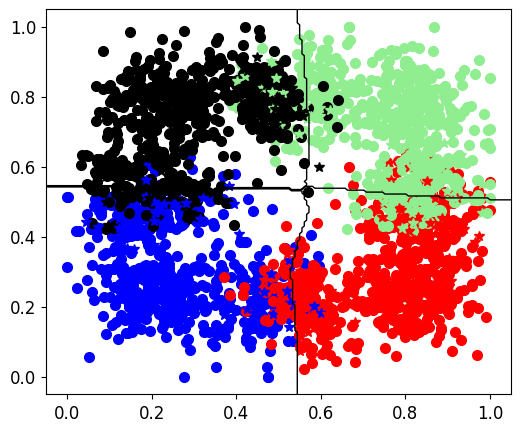

Adversarial training: iteration 8


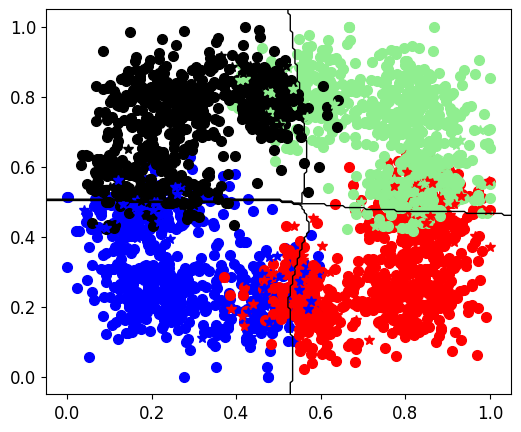

Adversarial training: iteration 9


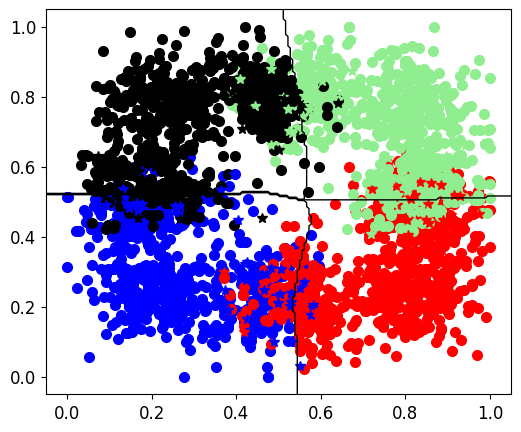

In [6]:
%matplotlib inline
from secml.data import CDataset
import sklearn
from secml.adv.attacks import CFoolboxPGDL2

# how many times a retrain the classifier
n_retrains = 10
# how many adverarial examples I want to compute
how_many_adv = 200
y_target = None
lb, ub = 0, 1

# create a ball of radius 0,2 around the adverarial examples (fixed)
eps = 0.2
alpha = 0.05 # learning rate
steps = 10 # number of steps
advtr_dataset = CDataset(tr.X, tr.Y) # we copy the clean classifier for later
at_clf = clean_clf.deepcopy()

# Classical PGD attack
pgd_attack = CFoolboxPGDL2(at_clf, y_target,
                           lb=lb, ub=ub,
                           epsilons=eps,
                           abs_stepsize=alpha,
                           steps=steps,
                           random_start=False)

for i in range(n_retrains):
    print(f'Adversarial training: iteration {i}')
    # I sample some indices without replacement from the original training set
    # I want to compute different adversarial examples
    indeces = sklearn.utils.random.sample_without_replacement(n_population=tr.X.shape[0], n_samples=how_many_adv).tolist()
    trY = tr.Y[indeces]

    # run attack on the classifier
    y_pred, _, adv_ds_pgd, _ = pgd_attack.run(tr.X[indeces,:], trY)

    # compute adversarial examples
    fig = CFigure(height=5, width=6)
    fig.sp.plot_ds(advtr_dataset, markers='o')
    fig.sp.plot_ds(CDataset(adv_ds_pgd.X, trY), markers='*')

    # we include the computed adversarial examples inside the training set
    advtr_dataset = advtr_dataset.append(CDataset(adv_ds_pgd.X, trY))

    # we fit the classifier with all the points
    at_clf.fit(advtr_dataset.X, advtr_dataset.Y)

    # this plot will show how the boundary changes over each iteration of the adversarial training
    fig.sp.plot_decision_regions(at_clf, plot_background=False, n_grid_points=200)
    fig.show()

After the completion of the adversarial training, we can compute the difference in robustness achieved.<br>

We can see that the adversarial training model is a bit more robust then the regular model.

In [7]:
# prediction of the clean model
ys_pred_y = clean_clf.predict(ts.X)
clean_accuracy = CMetricAccuracy().performance_score(ts.Y, ys_pred_y)
print('Clean accuracy of regular model: ', clean_accuracy)

ys_pred_y = at_clf.predict(ts.X)
clean_accuracy = CMetricAccuracy().performance_score(ts.Y, ys_pred_y)
print('Clean accuracy of AT model: ', clean_accuracy)

n_samples = 100
steps_2 = 5

# run the attack
pgd_attack_at = CFoolboxPGDL2(at_clf, y_target,
                           lb=lb, ub=ub,
                           epsilons=eps,
                           abs_stepsize=alpha,
                           steps=steps_2,
                           random_start=False)

# predictions of the adversarial trained model
at_adv_y_pred, _, _, _ = pgd_attack_at.run(ts.X[:n_samples, :], ts.Y[:n_samples])
at_robust_accuracy = CMetricAccuracy().performance_score(ts.Y[:n_samples], at_adv_y_pred)
print('Robust Accuracy of AT model:', at_robust_accuracy)

pgd_attack_clean = CFoolboxPGDL2(clean_clf, y_target,
                           lb=lb, ub=ub,
                           epsilons=eps,
                           abs_stepsize=alpha,
                           steps=steps_2,
                           random_start=False)

adv_y_pred, _, _, _ = pgd_attack_clean.run(ts.X[:n_samples, :], ts.Y[:n_samples])
robust_accuracy = CMetricAccuracy().performance_score(ts.Y[:n_samples], adv_y_pred)
print('Robust Accuracy of regular model:', robust_accuracy)

Clean accuracy of regular model:  1.0
Clean accuracy of AT model:  1.0
Robust Accuracy of AT model: 0.78
Robust Accuracy of regular model: 0.69


# High-dimensional examples: adversarially-robust MNIST classifier

Computing adversarial training on 2D problems is easy, but repeating the same loop for models trained on more complex problems (such as MNIST classification), the overall process becomes more and more complicated. We show here an example of robust. <br>
We instantiate two pretrained networks and we compute their robustness with adversarial attacks.


In [8]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/Colab Notebooks/Trustworthy AI'

Mounted at /content/drive


In [9]:
n_ts = 20  # number of testing samples

from secml.data.loader import CDataLoaderMNIST

loader = CDataLoaderMNIST()
mnist_ts = loader.load('testing', num_samples=n_ts)

# normalize the data
mnist_ts.X /= 255


File stored in `/root/secml-data/datasets/mnist/train-images-idx3-ubyte.gz`

File stored in `/root/secml-data/datasets/mnist/train-labels-idx1-ubyte.gz`

File stored in `/root/secml-data/datasets/mnist/t10k-images-idx3-ubyte.gz`

File stored in `/root/secml-data/datasets/mnist/t10k-labels-idx1-ubyte.gz`


In [10]:
from secml.ml.peval.metrics import CMetricAccuracy
from secml.ml import CClassifierPyTorch
from collections import OrderedDict
from torch import nn
import torch

class SmallCNN(nn.Module):
    def __init__(self, drop=0.5):
        super(SmallCNN, self).__init__()
        self.num_channels = 1
        self.num_labels = 10
        activ = nn.ReLU(True)
        self.feature_extractor = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(self.num_channels, 32, 3)),
            ('relu1', activ),
            ('conv2', nn.Conv2d(32, 32, 3)),
            ('relu2', activ),
            ('maxpool1', nn.MaxPool2d(2, 2)),
            ('conv3', nn.Conv2d(32, 64, 3)),
            ('relu3', activ),
            ('conv4', nn.Conv2d(64, 64, 3)),
            ('relu4', activ),
            ('maxpool2', nn.MaxPool2d(2, 2)),
        ]))
        self.classifier = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(64 * 4 * 4, 200)),
            ('relu1', activ),
            ('drop', nn.Dropout(drop)),
            ('fc2', nn.Linear(200, 200)),
            ('relu2', activ),
            ('fc3', nn.Linear(200, self.num_labels)),
        ]))

    def forward(self, input):
        features = self.feature_extractor(input)
        logits = self.classifier(features.view(-1, 64 * 4 * 4))
        return logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
regular_mnist_model = SmallCNN()
regular_mnist_model.load_state_dict(torch.load(path+'/mnist_net.pth', map_location=device))
regular_mnist_clf = CClassifierPyTorch(model=regular_mnist_model, pretrained=True, input_shape=(1, 28, 28))

robust_mnist_model = SmallCNN()
robust_mnist_model.load_state_dict(torch.load(path+'/mnist_robust_net.pth', map_location=device))
robust_mnist_model = CClassifierPyTorch(model=robust_mnist_model, pretrained=True, input_shape=(1, 28, 28))

metric = CMetricAccuracy()
reg_preds = regular_mnist_clf.predict(mnist_ts.X)
at_preds = robust_mnist_model.predict(mnist_ts.X)
reg_accuracy = metric.performance_score(y_true=mnist_ts.Y, y_pred=reg_preds)
at_accuracy = metric.performance_score(y_true=mnist_ts.Y, y_pred=at_preds)
print(f"Accuracy of regular net on test set: {reg_accuracy * 100}%")
print(f"Accuracy of robust net on test set: {at_accuracy * 100}%")

Accuracy of regular net on test set: 100.0%
Accuracy of robust net on test set: 100.0%


In [11]:
from secml.adv.attacks.evasion import CFoolboxPGDLinf

y_target = None
lb, ub = 0.0, 1.0
eps = 0.3  # this will be changed by the security evaluation class
alpha = 0.05
steps = 100

reg_attack = CFoolboxPGDLinf(regular_mnist_clf, y_target,
                         lb=lb, ub=ub,
                         epsilons=eps,
                         abs_stepsize=alpha,
                         steps=steps,
                         random_start=False)

at_attack = CFoolboxPGDLinf(robust_mnist_model, y_target,
                         lb=lb, ub=ub,
                         epsilons=eps,
                         abs_stepsize=alpha,
                         steps=steps,
                         random_start=False)

We compute the security evaluation curve on the given test set. This time, instead of a for loop, we will directly leverage another useful functionality of the SecML library: the **CSecEval class**. This class produce objects that help you computing security evaluation curves.
Here we instantiate a CsecEval object to repeat the instantiated attacks with different values of epsilon.

In [21]:
from secml.array import CArray

# perturbation levels to test
epsilon_vals = CArray.linspace(start=0, stop=1, num=10)

# Let's compute security evaluation with an increasing value of epsilon
from secml.adv.seceval import CSecEval

# security eval of not rubustly trained model
reg_sec_eval = CSecEval(attack=reg_attack, param_name='epsilon', param_values=epsilon_vals)
# security eval of robust model
at_sec_eval = CSecEval(attack=at_attack, param_name='epsilon', param_values=epsilon_vals)

# run the security evaluation using the test set
reg_sec_eval.run_sec_eval(mnist_ts)
at_sec_eval.run_sec_eval(mnist_ts)

We can finally plot the result of both security evaluations, and compare their drop with respect to the perturbation budget epsilon.

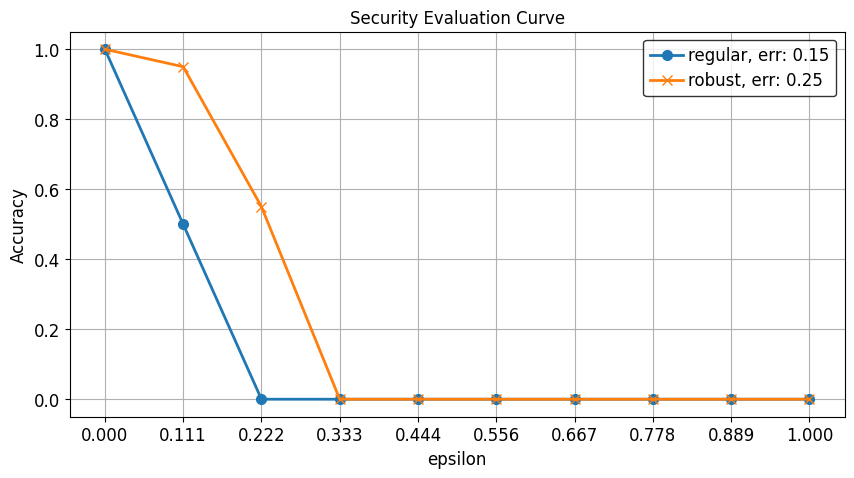

In [22]:
%matplotlib inline

from secml.figure import CFigure

fig = CFigure(height=5, width=10)

# convenience function for plotting the Security Evaluation Curve
fig.sp.plot_sec_eval(reg_sec_eval.sec_eval_data, marker='o', label='regular', show_average=True)
fig.sp.plot_sec_eval(at_sec_eval.sec_eval_data, marker='x', label='robust', show_average=True)
fig.show()

# RobustBench: an archive of adversarially-robust models

Another useful resource to consider while working with adversarial training is [**RobustBench**](https://github.com/RobustBench/robustbench), that is an open-source repository collecting the advancements in the state of the art of adversarial robustness.
Researchers train classifiers with complex techniques involving adversarial training. More details on the linked website.
Robustbench models can be imported inside SecML easily, as they all are coded in PyTorch.

In [18]:
try:
    import robustbench
except ImportError:
    %pip install git+https://github.com/RobustBench/robustbench.git

In [15]:
# NBVAL_IGNORE_OUTPUT

from robustbench.utils import load_model
from secml.data.loader.c_dataloader_cifar import CDataLoaderCIFAR10
from secml.ml.features.normalization import CNormalizerMinMax

model = load_model(model_name='Engstrom2019Robustness', norm='Linf', model_dir='.')
secml_model = CClassifierPyTorch(model, input_shape=(3,32,32), pretrained=True)
train_ds, test_ds = CDataLoaderCIFAR10().load()
normalizer = CNormalizerMinMax().fit(train_ds.X)
test_ds.X = normalizer.transform(test_ds.X)

Download started: path=cifar10/Linf/Engstrom2019Robustness.pt (gdrive_id=1etqmQsksNIWBvBQ4r8ZFk_3FJlLWr8Rr)
Download finished: path=cifar10/Linf/Engstrom2019Robustness.pt (gdrive_id=1etqmQsksNIWBvBQ4r8ZFk_3FJlLWr8Rr)

File stored in `/root/secml-data/datasets/cifar/cifar-10-python.tar.gz`


In [16]:
pgdlinf_attack = CFoolboxPGDLinf(secml_model, y_target,
                         lb=lb, ub=ub,
                         epsilons=0.031,
                         abs_stepsize=0.03,
                         steps=20,
                         random_start=False)

x0, y0 = test_ds.X[0,:], test_ds.Y[0]
y_pred_pgd, _, adv_ds_pgd, _ = pgdlinf_attack.run(x0, y0)

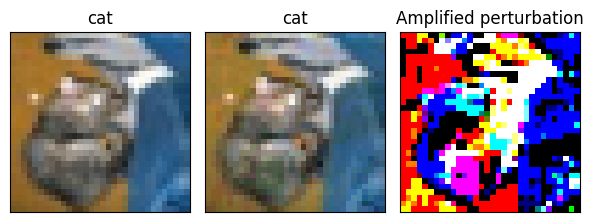

In [17]:
from secml.figure import CFigure
%matplotlib inline

dataset_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

img_normal = x0.tondarray().reshape((3,32,32)).transpose(2,1,0)
img_adv = adv_ds_pgd.X[0,:].tondarray().reshape((3,32,32)).transpose(2,1,0)

diff_img = img_normal - img_adv
diff_img -= diff_img.min()
diff_img /= diff_img.max()

fig = CFigure()
fig.subplot(1,3,1)
fig.sp.imshow(img_normal)
fig.sp.title('{0}'.format(dataset_labels[y0.item()]))
fig.sp.xticks([])
fig.sp.yticks([])

fig.subplot(1,3,2)
fig.sp.imshow(img_adv)
fig.sp.title('{0}'.format(dataset_labels[y_pred_pgd.item()]))
fig.sp.xticks([])
fig.sp.yticks([])


fig.subplot(1,3,3)
fig.sp.imshow(diff_img)
fig.sp.title('Amplified perturbation')
fig.sp.xticks([])
fig.sp.yticks([])
fig.tight_layout()
fig.show()